# ***Edge Detection & Hough Transform***

In [2]:
import numpy as np
from scipy.signal import convolve2d, correlate2d
import matplotlib.pyplot as plt
from Functions import *
from core import *

# Change default figure size
plt.rcParams["figure.figsize"] = (16, 10)

## 1) Difference operators

Original Image:
size: (256, 256)


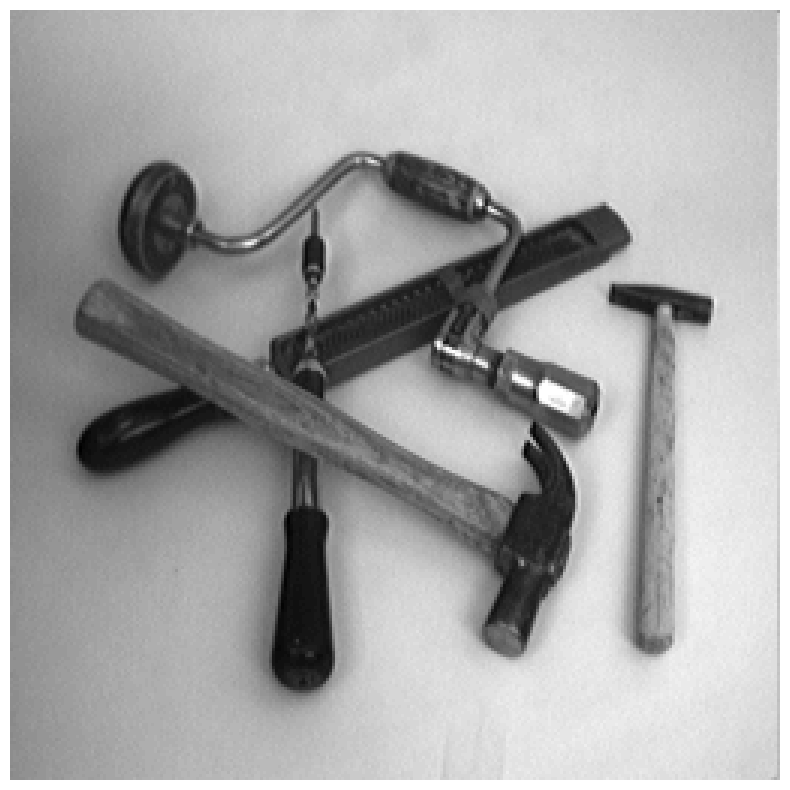

dx:
size: (252, 252)


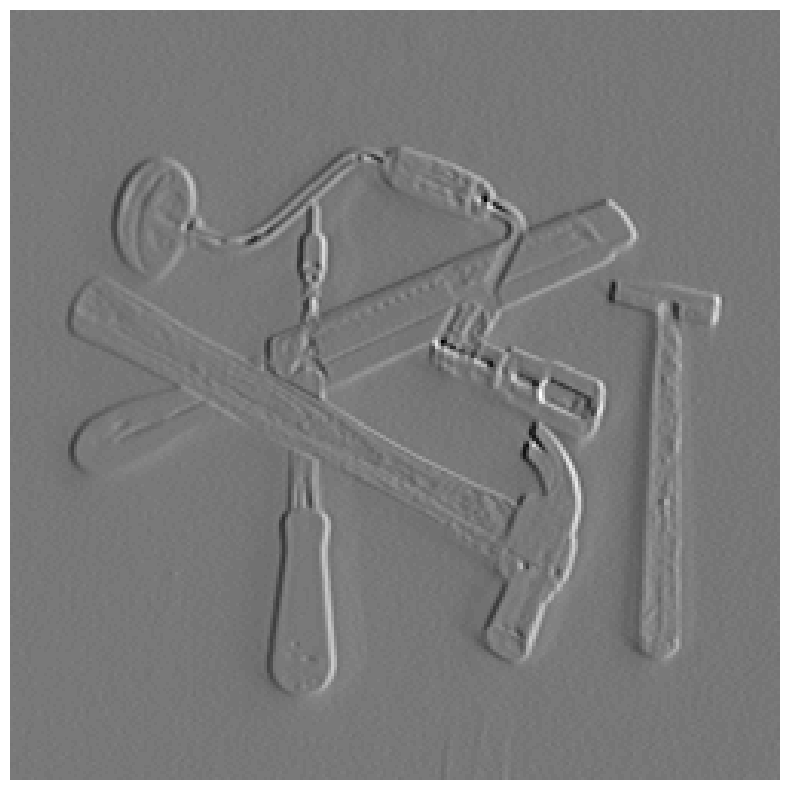

dy:
size: (252, 252)


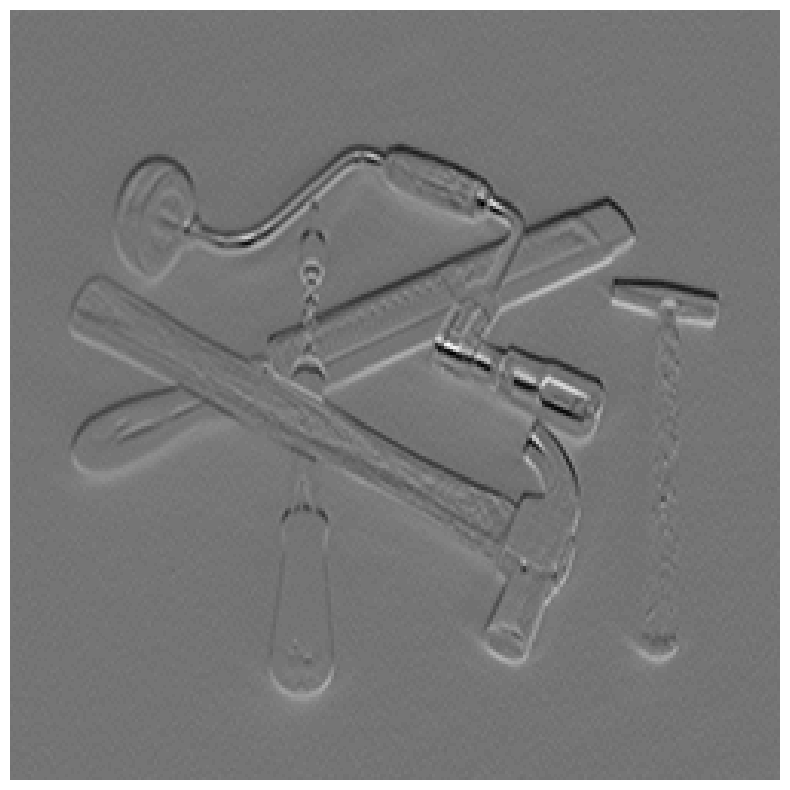

In [2]:
tools = np.load("Images-npy/few256.npy")

dxtools = convolve2d(tools, deltax(), 'valid')
dytools = convolve2d(tools, deltay(), 'valid')

print('Original Image:')
print('size: {}'.format(tools.shape))
showgrey(tools)
print('dx:')
print('size: {}'.format(dxtools.shape))
showgrey(dxtools)
print('dy:')
print('size: {}'.format(dytools.shape))
showgrey(dytools)

- I expect the results to highlight the edges and transition areas. More specifically, dx should emphasize transitions along x axis while dy should emphasize transitions along y axis.
- Tools is 256 x 256, dxtools is 254 x 254 because we can compute the difference operator on a pixel only if it has neigbhors in x and y directions (we need their values) -> the borders are removed

## 2) Point–wise thresholding of gradient magnitudes

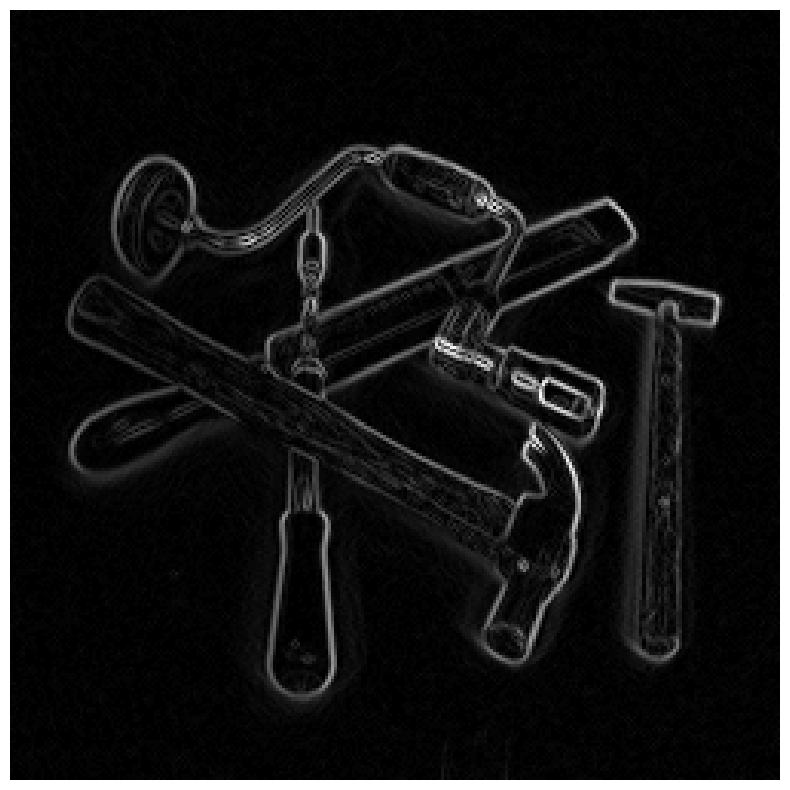

In [3]:
gradmagntools = np.sqrt(dxtools**2 + dytools**2)
showgrey(gradmagntools)

Histogram: [49449  6022  2680  1658   973   628   485   422   375   232   190   152
    65    56    36    27    24    16     8     6]
Bin edges: [  0.           6.13117036  12.26234072  18.39351108  24.52468145
  30.65585181  36.78702217  42.91819253  49.04936289  55.18053325
  61.31170361  67.44287397  73.57404434  79.7052147   85.83638506
  91.96755542  98.09872578 104.22989614 110.3610665  116.49223687
 122.62340723]


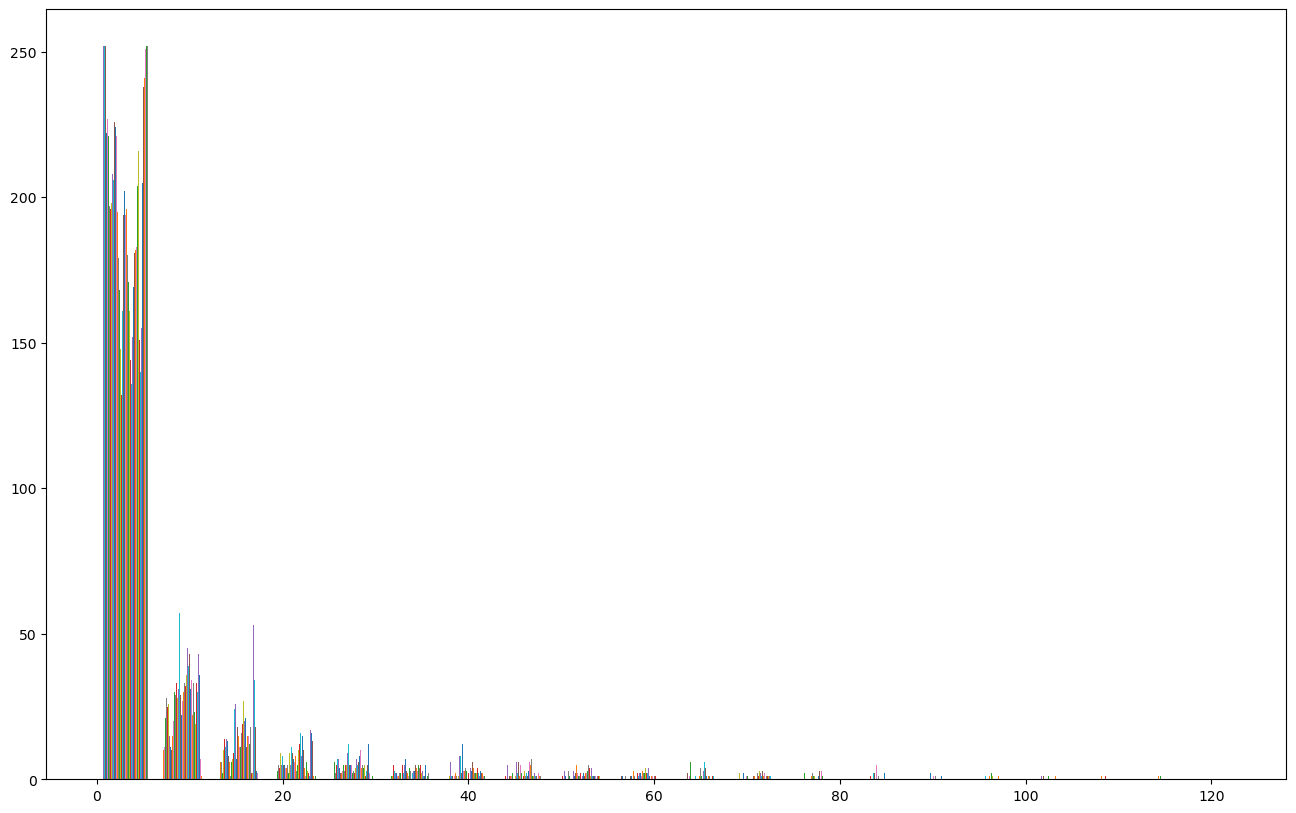

In [4]:
hist, bin_edges = np.histogram(gradmagntools, bins=20)

print('Histogram:', hist)
print('Bin edges:', bin_edges)

plt.hist(gradmagntools, bins=20)
plt.show()

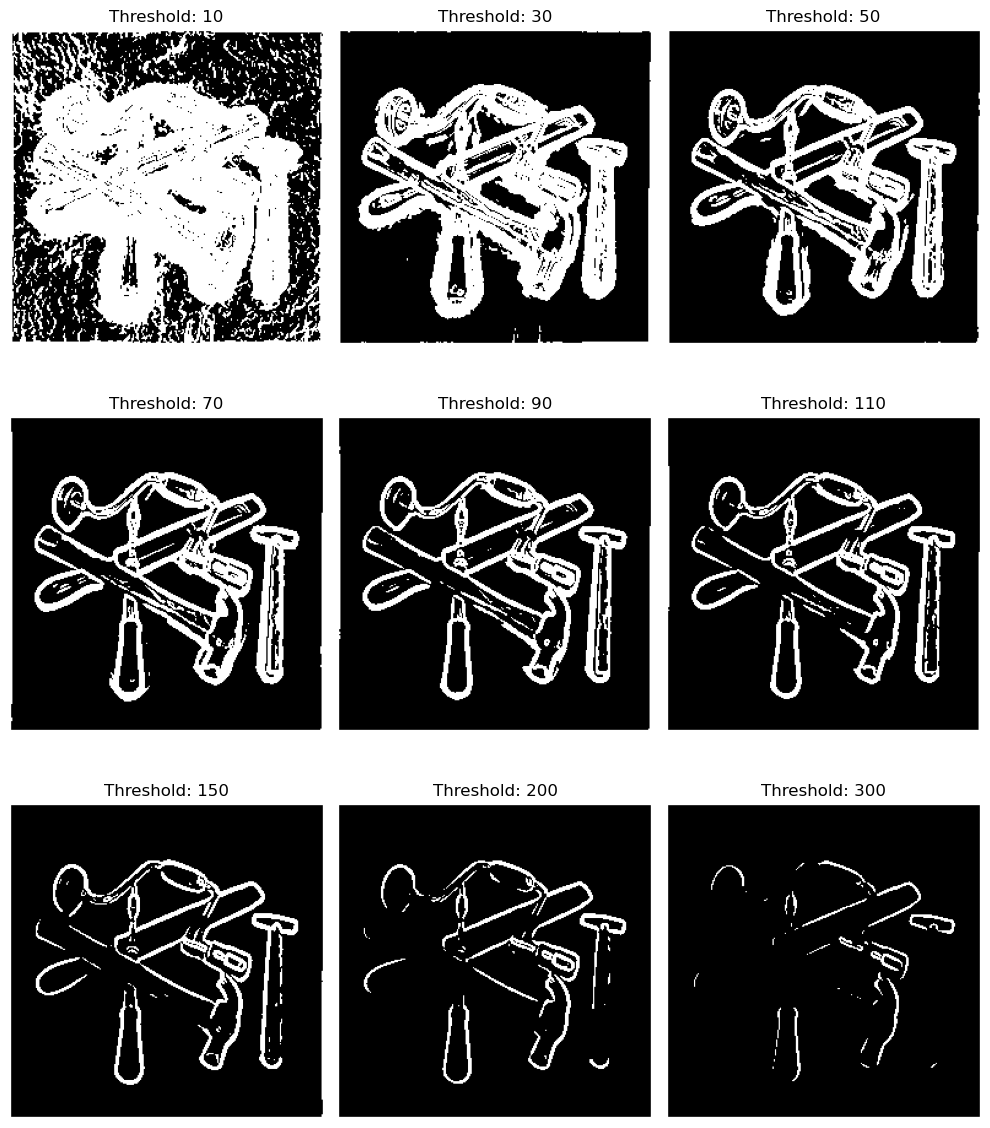

In [5]:
smooth_tools = gaussfft(tools, 1.0)
thresholds = [10, 30, 50, 70, 90, 110, 150, 200, 300]

fig = plt.figure(figsize=(10, 12))

for i in range(3):
    for j in range(3):
        idx = i * 3 + j
        ax = fig.add_subplot(3, 3, idx + 1)
    
        grad = Lv(smooth_tools)
        threshold = thresholds[idx]
        showgrey((grad > threshold).astype(int), display=False)
        ax.set_title('Threshold: {}'.format(threshold))
        
        ax.axis('off')

plt.tight_layout()
plt.show()

Histogram: [3232  980 1137 1241 1679 1896 2308 2269 2447 2510 2586 2163 3043 4639
 6771 6930 5507 2133 2498 9567]
Bin edges: [  0.    12.75  25.5   38.25  51.    63.75  76.5   89.25 102.   114.75
 127.5  140.25 153.   165.75 178.5  191.25 204.   216.75 229.5  242.25
 255.  ]


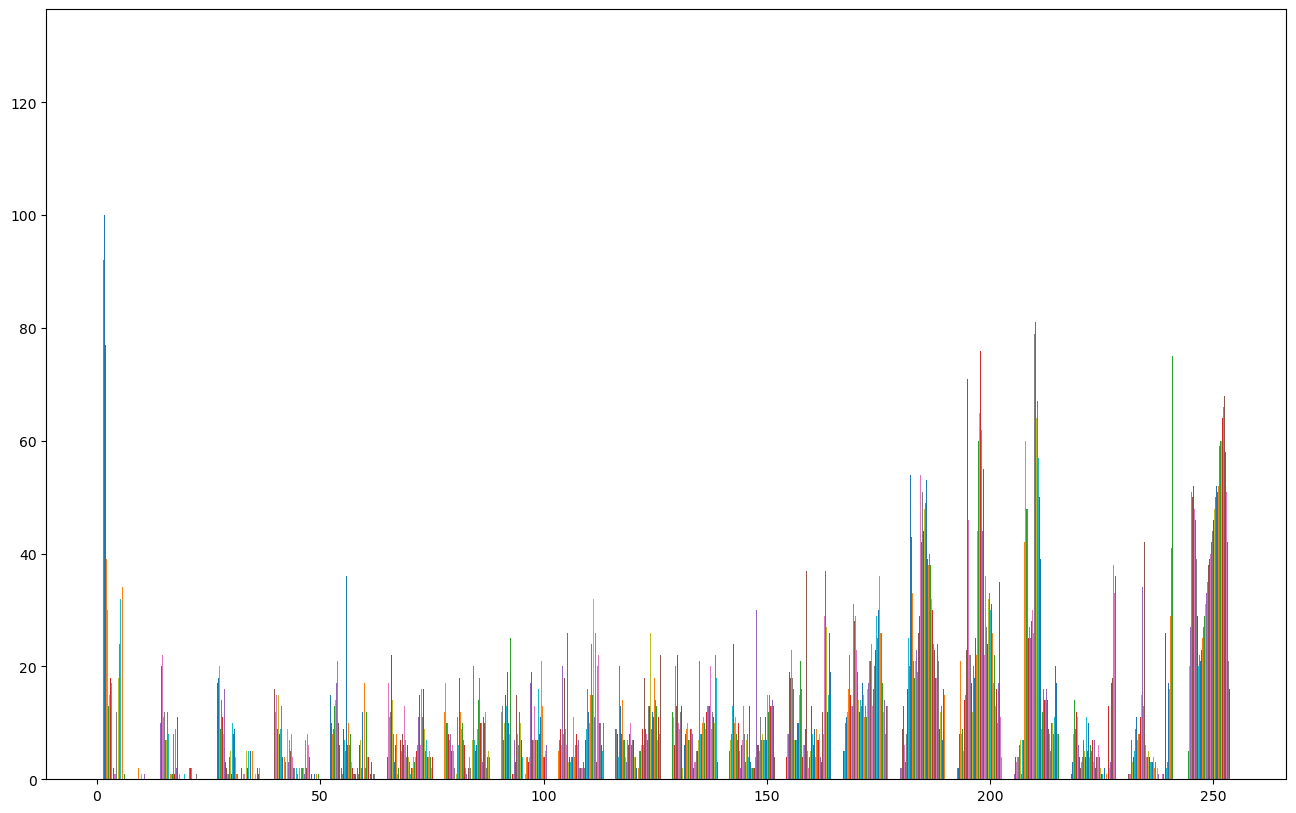

In [6]:
godthem = np.load("Images-npy/godthem256.npy")

hist, bin_edges = np.histogram(godthem, bins=20)

print('Histogram:', hist)
print('Bin edges:', bin_edges)

plt.hist(godthem, bins=20)
plt.show()

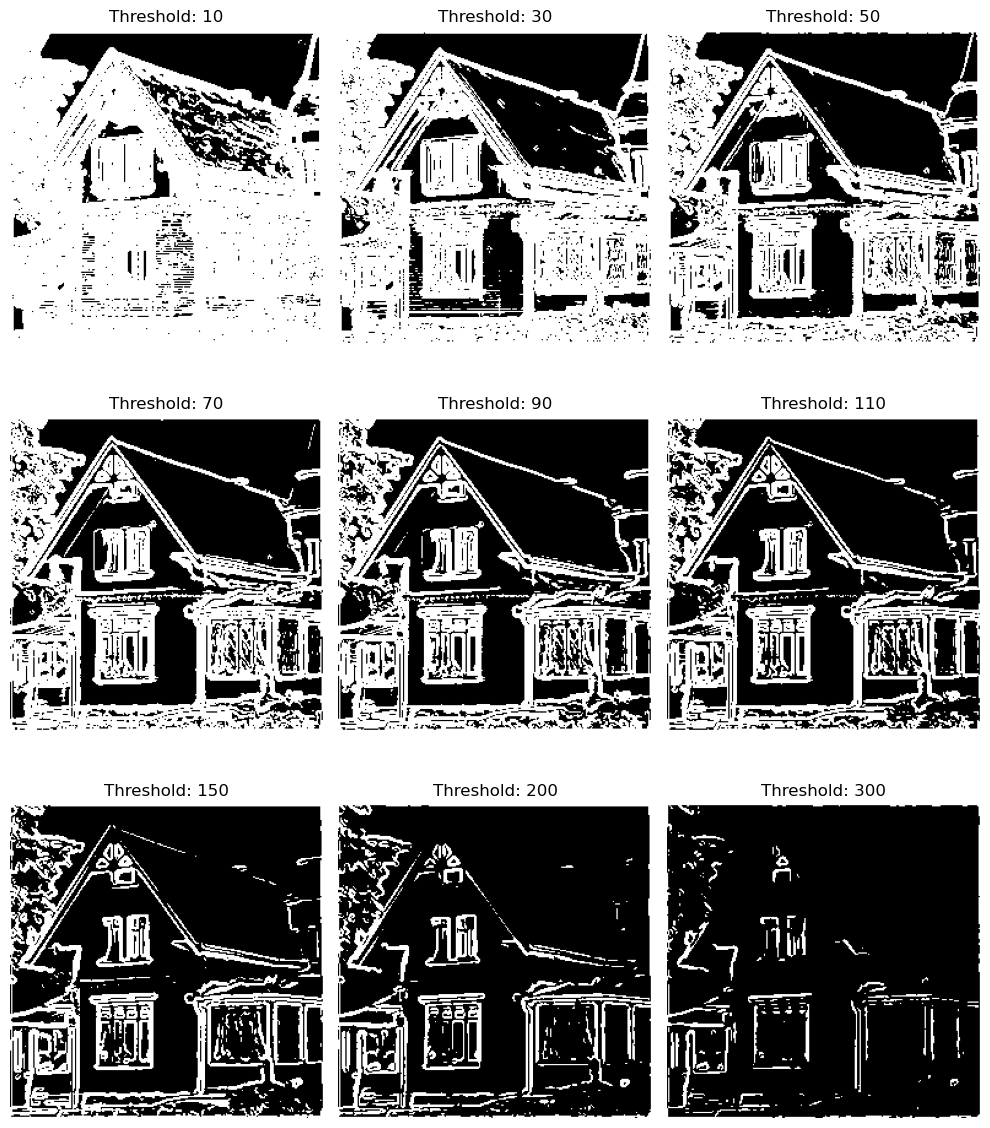

In [7]:
godthem = np.load("Images-npy/godthem256.npy")
smooth_godthem = gaussfft(godthem, 1.0)
thresholds = [10, 30, 50, 70, 90, 110, 150, 200, 300]

fig = plt.figure(figsize=(10, 12))

for i in range(3):
    for j in range(3):
        idx = i * 3 + j
        ax = fig.add_subplot(3, 3, idx + 1)
    
        grad = Lv(smooth_godthem)
        threshold = thresholds[idx]
        showgrey((grad > threshold).astype(int), display=False)
        ax.set_title('Threshold: {}'.format(threshold))
        
        ax.axis('off')

plt.tight_layout()
plt.show()

- Large threshold: gives thin edges but some of them are being fragmented, disconnected
- Small threshold: results in thicker edges, detects more of them (including weak or noisy ones)

### Effect of smoothing

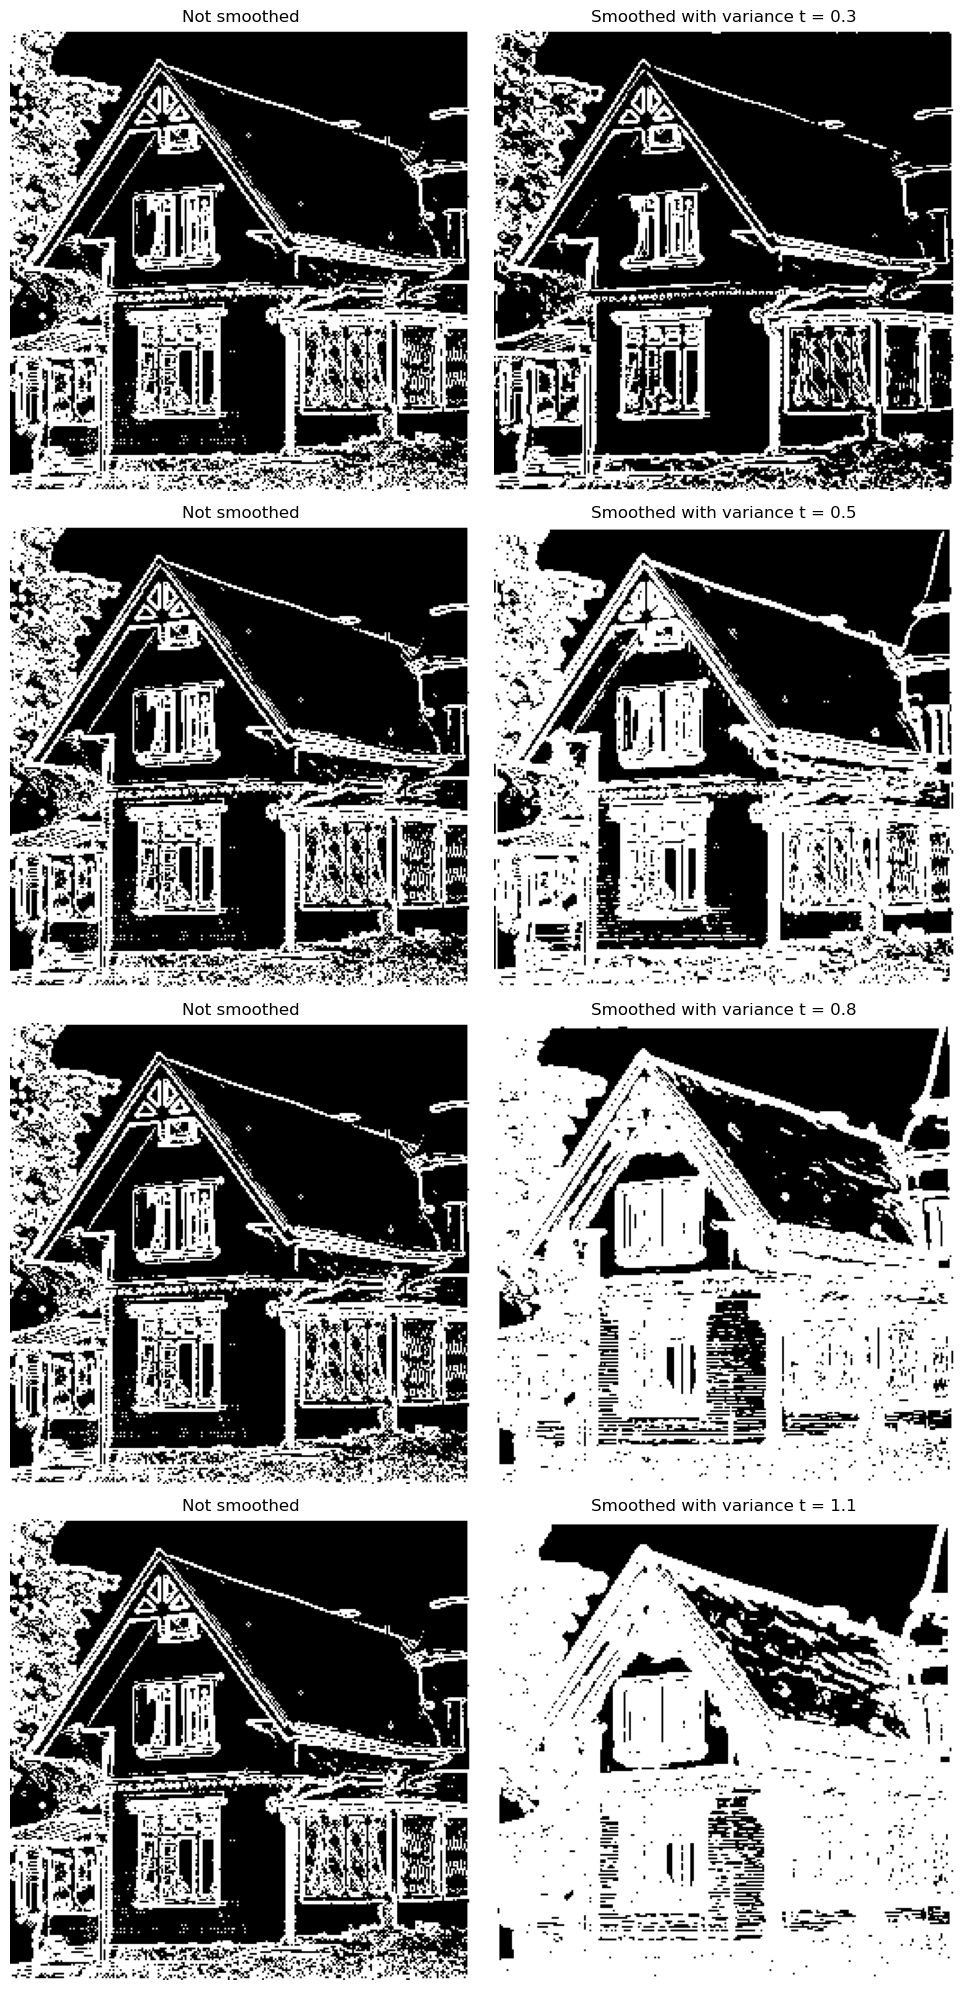

In [8]:
godthem = np.load("Images-npy/godthem256.npy")

T = [0.3, 0.5, 0.8, 1.1]
threshold = 15
fig = plt.figure(figsize=(10, 20))

for i in range(4):
    for j in range(2):
        idx = i * 2 + j
        ax = fig.add_subplot(4, 2, idx + 1)

        if j == 1:
            t = T[i]
            smooth_godthem = gaussfft(godthem, t)
            grad_smooth = Lv(smooth_godthem)
            showgrey((grad_smooth > threshold).astype(int), display=False)
            ax.set_title('Smoothed with variance t = {}'.format(t))
        else:
            grad = Lv(godthem)
            showgrey((grad > threshold).astype(int), display=False)
            ax.set_title('Not smoothed')
        
        ax.axis('off')

plt.tight_layout()
plt.show()

Smoothing the image helps find the edges because of noise reduction: noise can produce high gradient magnitude in non-edge regions, so removing it allows to more accurately focus on actual edges (remove the "false positives").

However, the level of smoothing needs to be chosen carefully because if it is too high, it makes actual edges thicker, and we face distortions of the "true" structures.

## 3) Differential geometry descriptors 

**One way of extracting thin edges is by considering points for which the gradient magnitude reaches local maxima in gradient direction.**

This edge definition can be expressed in differential geometry terms as the second order derivative being equal to zero and the third order derivative being negative.

Here, we compute the derivative with respect to $x$ and $y$ -> gives, for each pixel, a vector pointing in the increasing direction, with a magnitude proportional to the increase (we get this magnitude in Lv). However, pixels from a whole region could have gradient pointing in the same direction (especially if we have smoothed before) -> to find the point in which the edge is more likely to be, we want to find the point in which the gradient is maximum -> **we have to compute its derivative in its direction**. Therefore, we introduce a new basis $(u,v)$, where $v$ is parrallel to the gradient, allowing to compute the right derivative directly in the Cartesian coordinate directions thanks to a rotation vector.

### Second order derivative

(256, 256) (256, 256) (256, 256)
(256, 256) (256, 256) (256, 256)
(256, 256) (256, 256) (256, 256)
(256, 256) (256, 256) (256, 256)
(256, 256) (256, 256) (256, 256)


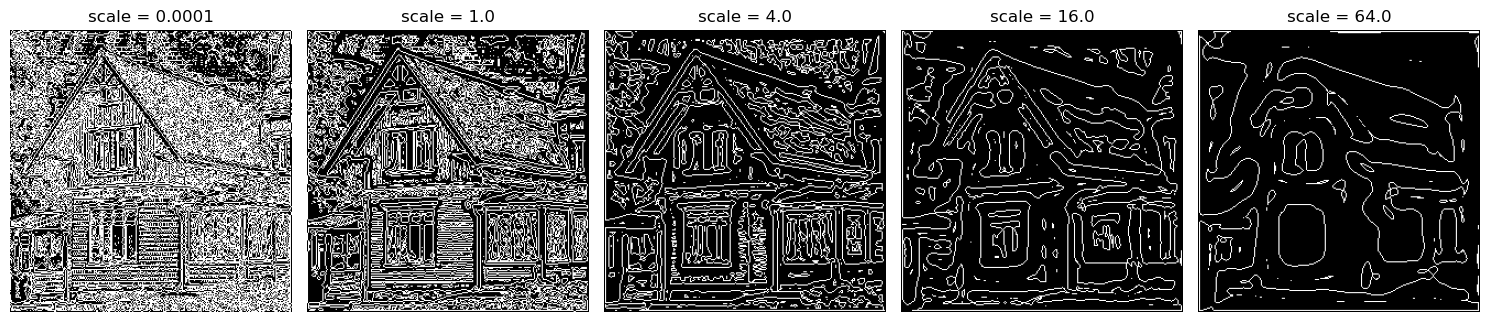

In [10]:
house = np.load("Images-npy/godthem256.npy")
T = [0.0001, 1.0, 4.0, 16.0, 64.0]
f = plt.figure(figsize=(15, 5))

for i in range(5):
    scale = T[i]
    
    ax = f.add_subplot(1, 5, i + 1)
    ax.set_title('scale = {}'.format(scale))
    ax.axis('off')
    showgrey(contour(Lvvtilde(discgaussfft(house, scale), 'same')), display=False)

plt.tight_layout()
plt.show()

Here we're looking at the first condition: zero crossing of the second order derivative i.e local optima of the gradient magnitude, in its direction.

We observe:
- thiner edges (width = one pixel)
- for low scale: a lot of "false" edges in smooth areas because of an insufficient noise reduction and because of the gradient's minima
- for high scale: better noise reduction but distortion of the "true" structures

### Third order derivative

(256, 256) (256, 256) (256, 256)
(256, 256) (256, 256) (256, 256)
(256, 256) (256, 256) (256, 256)
(256, 256) (256, 256) (256, 256)
(256, 256) (256, 256) (256, 256)


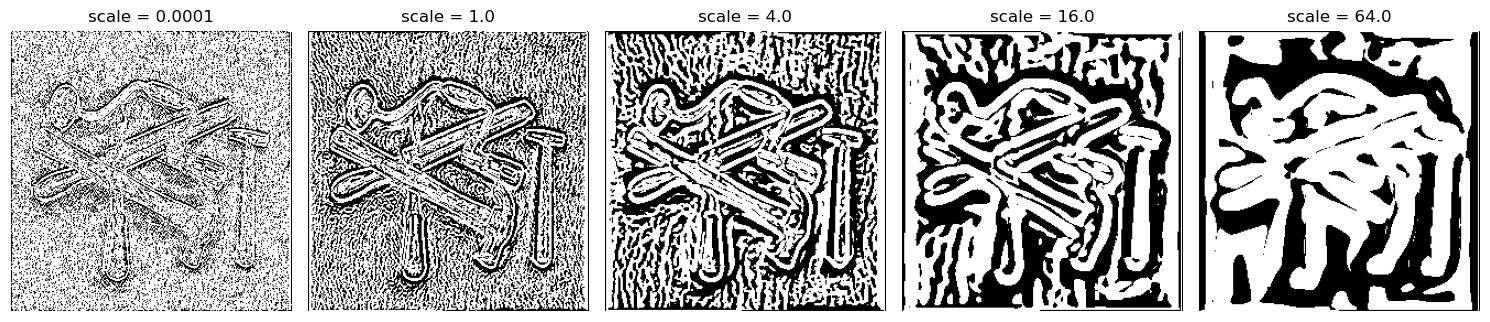

In [11]:
tools = np.load("Images-npy/few256.npy")
T = [0.0001, 1.0, 4.0, 16.0, 64.0]
f = plt.figure(figsize=(15, 5))

for i in range(5):
    scale = T[i]
    
    ax = f.add_subplot(1, 5, i + 1)
    ax.set_title('scale = {}'.format(scale))
    ax.axis('off')
    showgrey((Lvvvtilde(discgaussfft(tools, scale), 'same')<0).astype(int), display=False)

plt.tight_layout()
plt.show()

Now we're looking at the second condition: regions where the third order deriavtive is negative i.e where the the second order derivative is decreasing i.e where the gradient is increasing more and more slowly.

### Combination

(256, 256) (256, 256) (256, 256)
(256, 256) (256, 256) (256, 256)
(256, 256) (256, 256) (256, 256)
(256, 256) (256, 256) (256, 256)
(256, 256) (256, 256) (256, 256)
(256, 256) (256, 256) (256, 256)
(256, 256) (256, 256) (256, 256)
(256, 256) (256, 256) (256, 256)
(256, 256) (256, 256) (256, 256)
(256, 256) (256, 256) (256, 256)


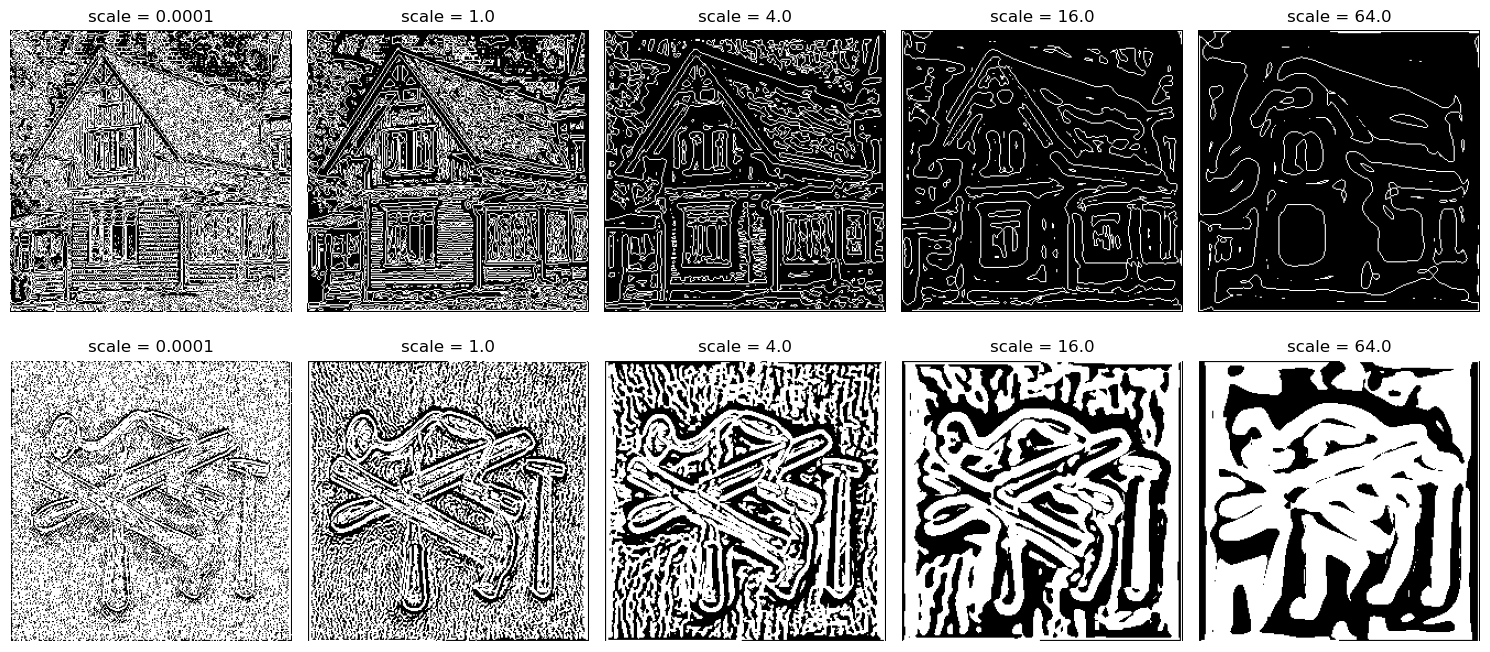

In [12]:
tools = np.load("Images-npy/few256.npy")
house = np.load("Images-npy/godthem256.npy")
T = [0.0001, 1.0, 4.0, 16.0, 64.0]
f = plt.figure(figsize=(15, 7))

for i in range(2):
    for j in range(5):
        idx = i * 5 + j
        ax = f.add_subplot(2, 5, idx + 1)

        if i == 0:
            scale = T[idx]
            ax.set_title('scale = {}'.format(scale))
            showgrey(contour(Lvvtilde(discgaussfft(house, scale), 'same')), display=False)
            
        else:
            scale = T[idx-5]
            ax.set_title('scale = {}'.format(scale))
            ax.axis('off')
            showgrey((Lvvvtilde(discgaussfft(tools, scale), 'same')<0).astype(int), display=False)

        ax.axis('off')
        
plt.tight_layout()
plt.show()

- Lvv highlights the regions where the gradient is locally optimal in its direction -> gives us the edges with the maxima but also meaningless smooth regions with minima
  
- Lvvv highlights the regions where the gradient's increasing rate is getting larger or smaller -> if we only select the areas in which the increasing rate is getting slower and where the gradient is reaching an optima, we get the maxima

Effect of smoothing:

- The smoothing allows effective noise reduction in both cases because the gradient is smoother.

- For the gradient optima $L_{vv}$ as discussed above, high smoothing leads to severe distortion of the structures.

- For $L_{vvv}$, the detection areas are getting wider and overlap each other as the scale increases, which will lead to more edge detections (including non-relevant ones).

So again, a balance needs to be found to make edge detection efficient.

### Extraction of edge segments

Scale selection:

(256, 256) (256, 256) (256, 256)
(256, 256) (256, 256) (256, 256)
(256, 256) (256, 256) (256, 256)
(256, 256) (256, 256) (256, 256)
(256, 256) (256, 256) (256, 256)
(256, 256) (256, 256) (256, 256)
(256, 256) (256, 256) (256, 256)
(256, 256) (256, 256) (256, 256)
(256, 256) (256, 256) (256, 256)
(256, 256) (256, 256) (256, 256)


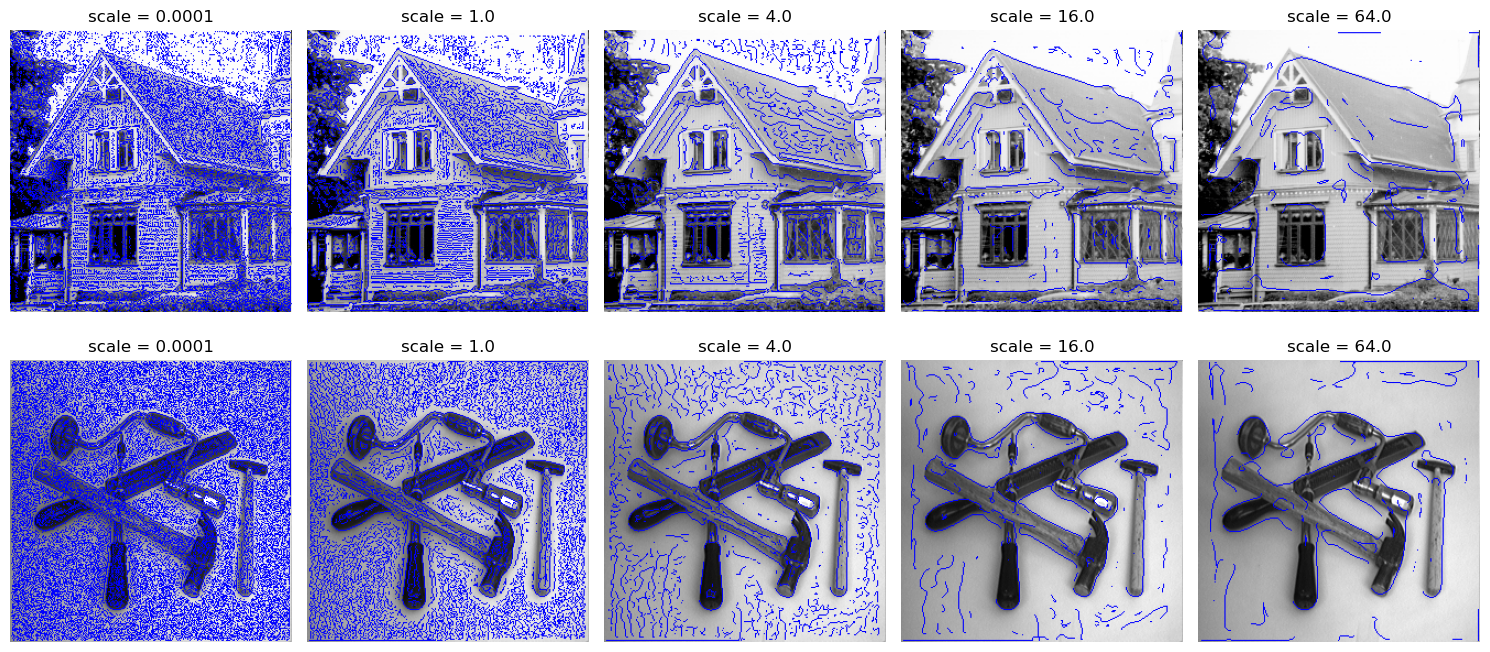

In [13]:
tools = np.load("Images-npy/few256.npy")
house = np.load("Images-npy/godthem256.npy")
T = [0.0001, 1.0, 4.0, 16.0, 64.0]
f = plt.figure(figsize=(15, 7))

for i in range(2):
    for j in range(5):
        idx = i * 5 + j
        ax = f.add_subplot(2, 5, idx + 1)

        if i == 0:
            scale = T[idx]
            ax.set_title('scale = {}'.format(scale))
            edgecurves = extractedge(house, scale, 'same')
            overlaycurves(house, edgecurves)
        else:
            scale = T[idx-5]
            ax.set_title('scale = {}'.format(scale))
            edgecurves = extractedge(tools, scale, 'same')
            overlaycurves(tools, edgecurves)
            
        ax.axis('off')
        
plt.tight_layout()
plt.show()

Threshold selection:

(256, 256) (256, 256) (256, 256)
(256, 256) (256, 256) (256, 256)
(256, 256) (256, 256) (256, 256)
(256, 256) (256, 256) (256, 256)
(256, 256) (256, 256) (256, 256)
(256, 256) (256, 256) (256, 256)
(256, 256) (256, 256) (256, 256)
(256, 256) (256, 256) (256, 256)
(256, 256) (256, 256) (256, 256)
(256, 256) (256, 256) (256, 256)


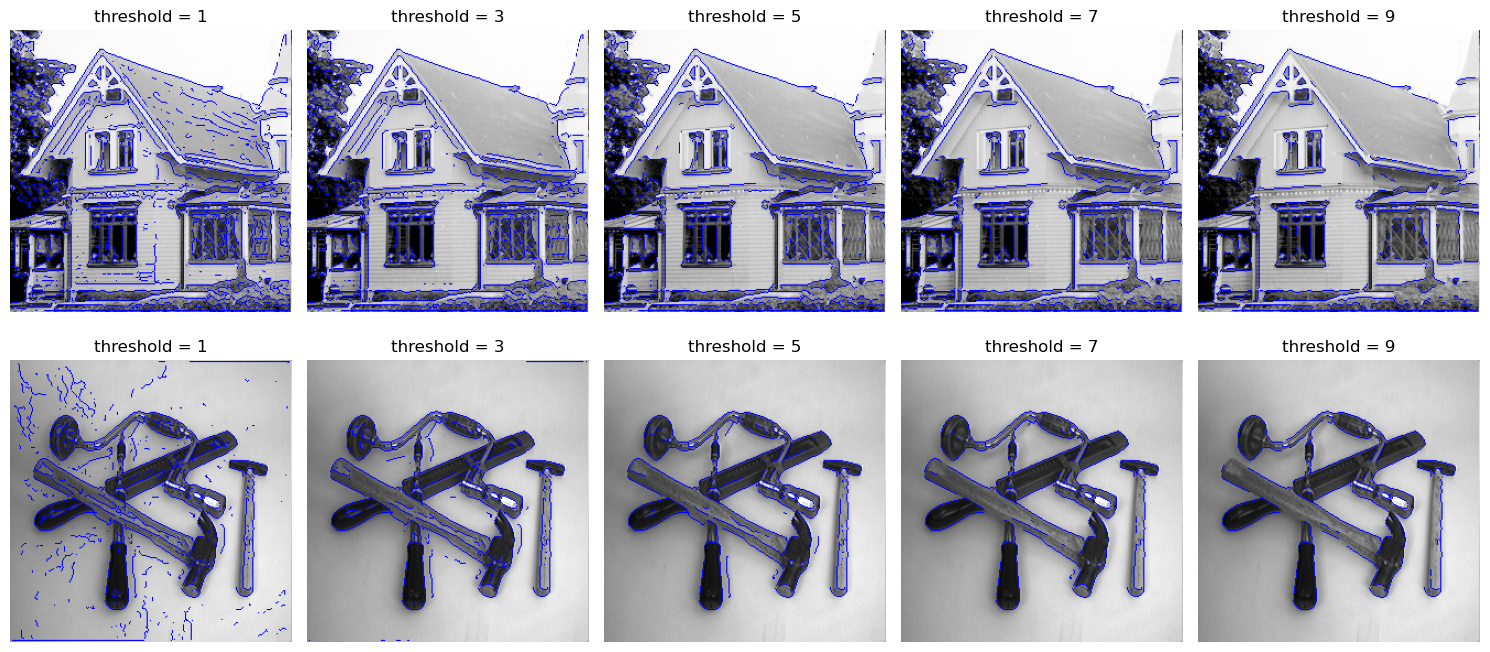

In [14]:
tools = np.load("Images-npy/few256.npy")
house = np.load("Images-npy/godthem256.npy")
T = [1, 3, 5, 7, 9]
f = plt.figure(figsize=(15, 7))
scale = 3.0

for i in range(2):
    for j in range(5):
        idx = i * 5 + j
        ax = f.add_subplot(2, 5, idx + 1)

        if i == 0:
            threshold = T[idx]
            ax.set_title('threshold = {}'.format(threshold))
            edgecurves = extractedge(house, scale, 'same', threshold=threshold)
            overlaycurves(house, edgecurves)
        else:
            threshold = T[idx-5]
            ax.set_title('threshold = {}'.format(threshold))
            edgecurves = extractedge(tools, scale, 'same', threshold=threshold)
            overlaycurves(tools, edgecurves)
            
        ax.axis('off')
        
plt.tight_layout()
plt.show()

Best results:

(256, 256) (256, 256) (256, 256)
(256, 256) (256, 256) (256, 256)


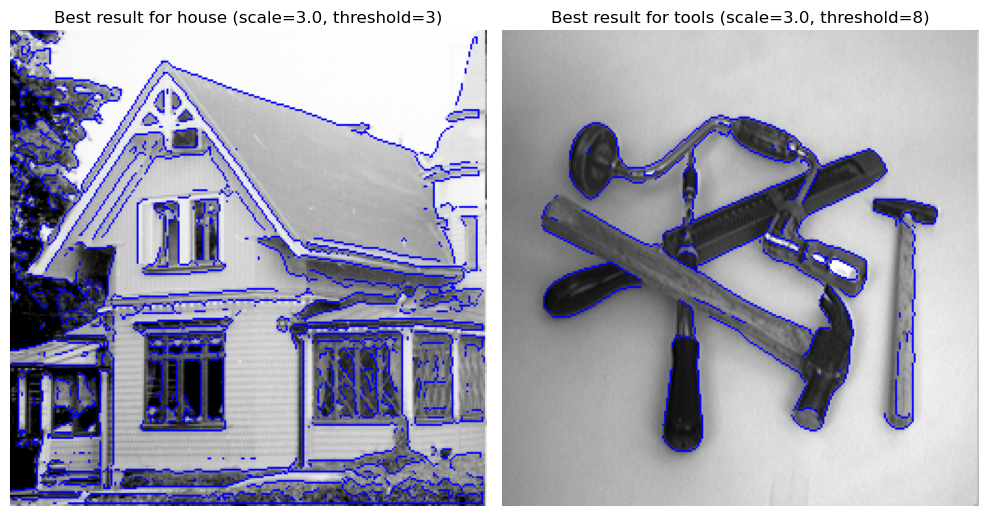

In [15]:
tools = np.load("Images-npy/few256.npy")
house = np.load("Images-npy/godthem256.npy")
scale = 3.0
fig = plt.figure(figsize=(10, 20))

for i in range(1):
    for j in range(2):
        idx = i * 2 + j
        ax = fig.add_subplot(4, 2, idx + 1)

        if j == 1:
            threshold = 8
            ax.set_title('Best result for tools (scale={}, threshold={})'.format(scale, threshold))
            edgecurves = extractedge(tools, scale, 'same', threshold=threshold)
            overlaycurves(tools, edgecurves)
        else:
            threshold = 3
            ax.set_title('Best result for house (scale={}, threshold={})'.format(scale, threshold))
            edgecurves = extractedge(house, scale, 'same', threshold=threshold)
            overlaycurves(house, edgecurves)
        
        ax.axis('off')

plt.tight_layout()
plt.show()

## 4) Hough Transform

**Hough transform = method to transform edge points into actual lines**

Note: we use polar coordinates to avoid instability for vertical lines (slope -> infinity)

**Algorithm:**
- for each edge point:
    - for each $\theta$: (i.e we change the slope of the line)
        - we compute the corresponding $\rho$ (to make sure that the line still cross the point)
        - we update the accumulator (i.e we plot a point that represent a possible line for the given edge point)
        - at the end we have ploted the whole curve $\rho=f(\theta)$ for this edge point, representing all the possible lines that cross it

**Note: each point in the accumulator space corresponds to a line in the image space -> an intersections in the accumulator space mean that, for these parameters $(\rho_0, \theta_0)$, several edge points are on the same line**

### Correspondences between the strongest peaks in the accumulator and line segments in the output image

[[0.0625 0.125  0.0625]
 [0.125  0.25   0.125 ]
 [0.0625 0.125  0.0625]]
[[0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.25 0.  ]
 [0.   0.   0.   0.  ]]
(128, 128) (128, 128) (128, 128)
(362, 180) (362, 180) (362, 180)


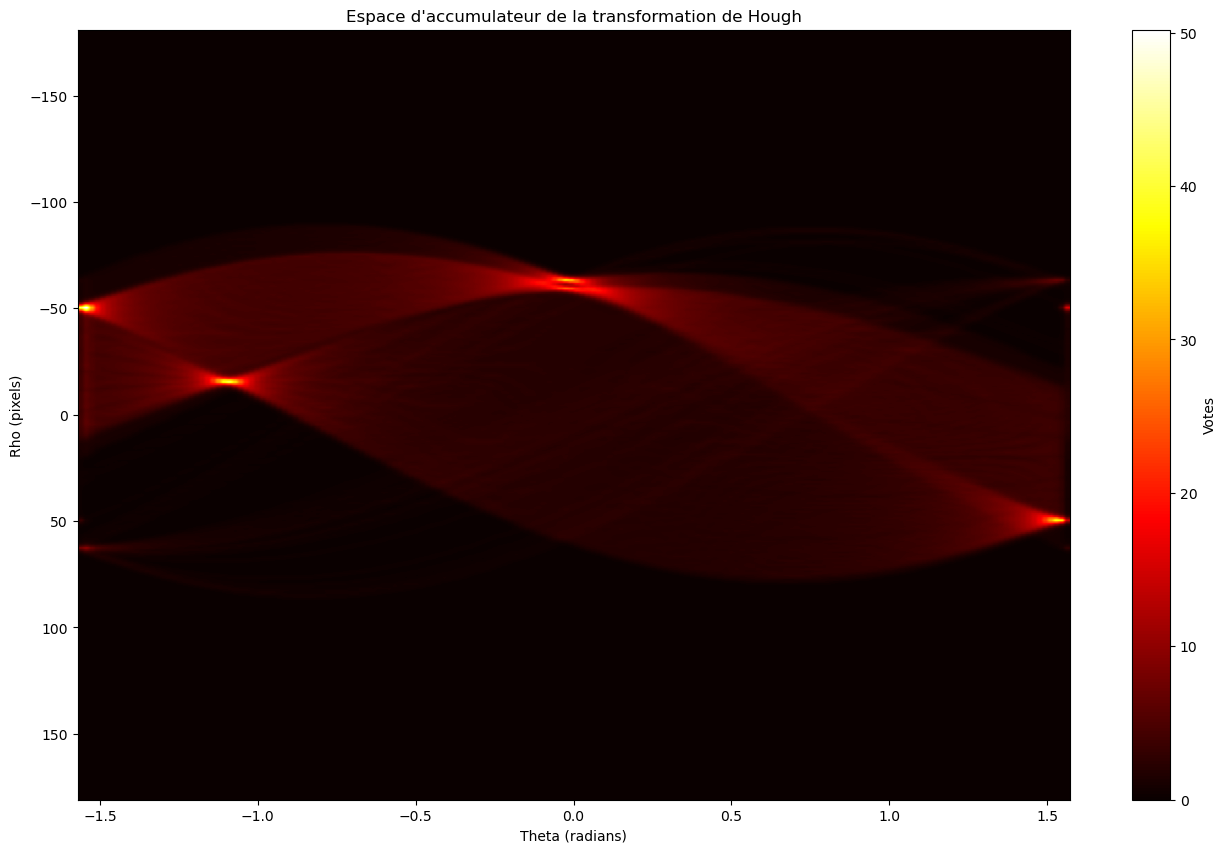

(128, 128) (128, 128) (128, 128)
(362, 180) (362, 180) (362, 180)


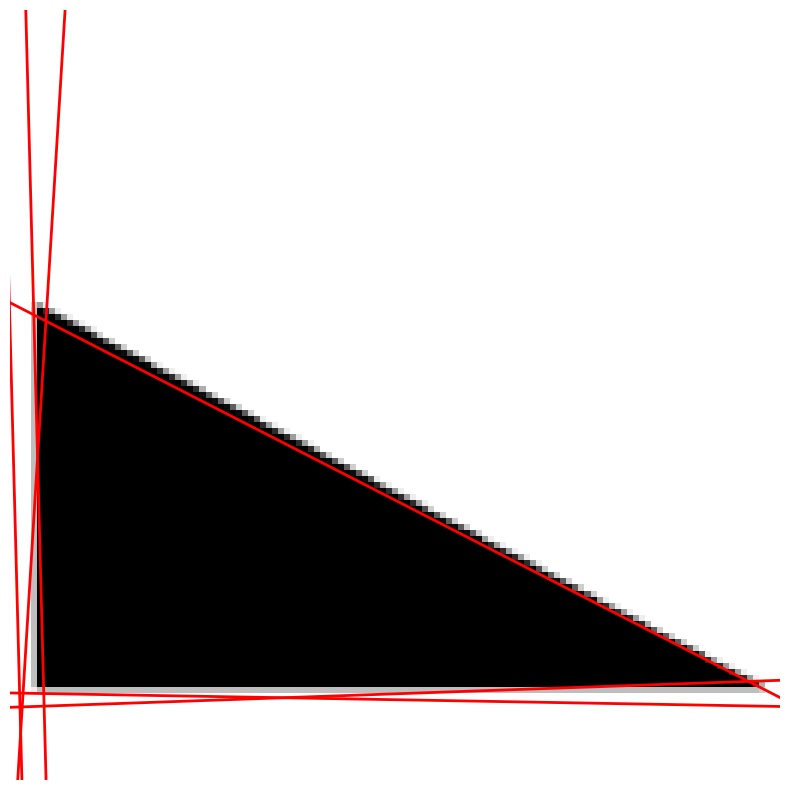

In [2]:
testimage1 = np.load("Images-npy/triangle128.npy")
smalltest1 = binsubsample(testimage1)

pic = testimage1
scale = 1
gradmagnthreshold = 20
nlines = 6
H,W = pic.shape

# theta
dtheta = np.pi / 180 # one degree
theta_max = np.pi / 2
ntheta = int(2*theta_max / dtheta)
print(deltaxy())
# rho
drho = 1 # one pixel
rho_max = np.sqrt((W)**2 + (H)**2)
nrho = int(2*rho_max / drho)

houghedgeline(pic, scale, gradmagnthreshold, nrho, ntheta, nlines, verbose = 1)
houghedgeline(pic, scale, gradmagnthreshold, nrho, ntheta, nlines, verbose = 2)

- Peaks in $\theta=-\frac{\pi}{2}$ and $\theta=\frac{\pi}{2}$ -> horizontal line
- Peak in $\theta=0$ -> vertical line
- Last peak -> hypothenuse

[[0.0625 0.125  0.0625]
 [0.125  0.25   0.125 ]
 [0.0625 0.125  0.0625]]
[[0.0625 0.125  0.0625]
 [0.125  0.25   0.125 ]
 [0.0625 0.125  0.0625]]
(256, 256) (256, 256) (256, 256)
(724, 180) (724, 180) (724, 180)


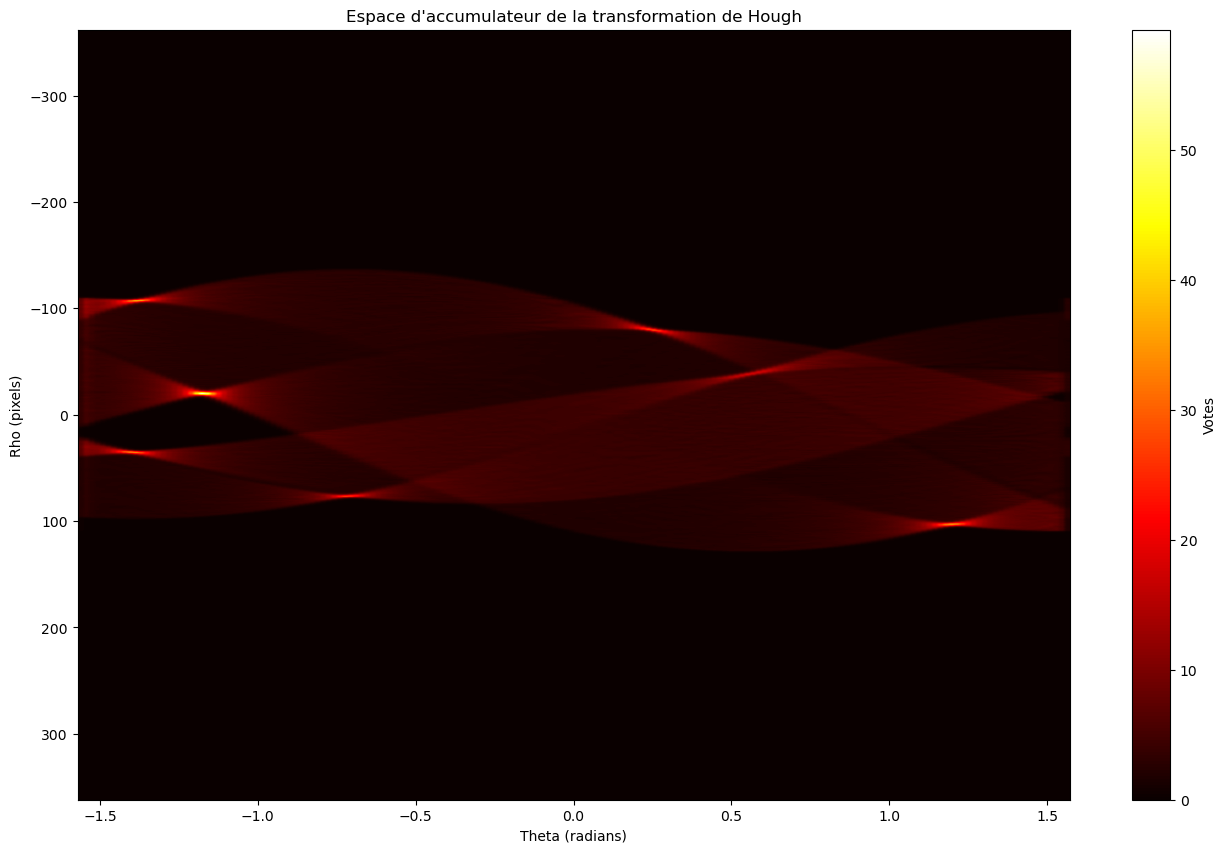

(256, 256) (256, 256) (256, 256)
(724, 180) (724, 180) (724, 180)


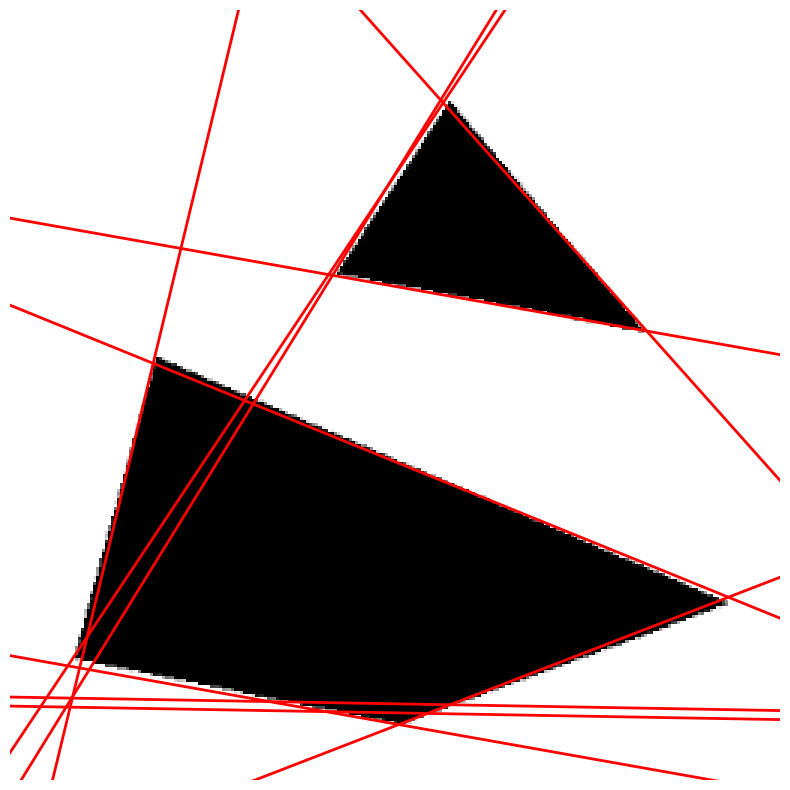

In [5]:
testimage2 = np.load("Images-npy/houghtest256.npy")
smalltest2 = binsubsample(binsubsample(testimage2))

pic = testimage2
scale = 5
gradmagnthreshold = 10
nlines = 10
H,W = pic.shape

# theta
dtheta = np.pi / 180 # one degree
theta_max = np.pi / 2
ntheta = int(2*theta_max / dtheta)

# rho
drho = 1 # one pixel
rho_max = np.sqrt((W)**2 + (H)**2)
nrho = int(2*rho_max / drho)

houghedgeline(pic, scale, gradmagnthreshold, nrho, ntheta, nlines, verbose = 1)
houghedgeline(pic, scale, gradmagnthreshold, nrho, ntheta, nlines, verbose = 2)

(256, 256) (256, 256) (256, 256)
(724, 180) (724, 180) (724, 180)
(256, 256) (256, 256) (256, 256)
(724, 180) (724, 180) (724, 180)
(256, 256) (256, 256) (256, 256)
(724, 180) (724, 180) (724, 180)


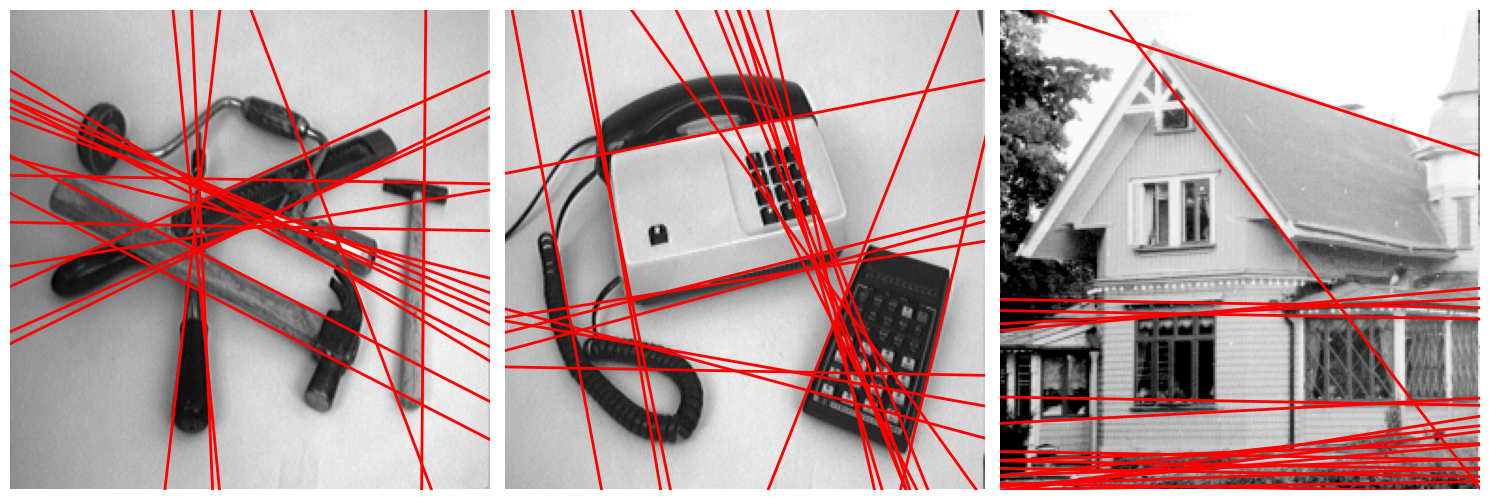

In [20]:
tools = np.load("Images-npy/few256.npy")
phone = np.load("Images-npy/phonecalc256.npy")
house = np.load("Images-npy/godthem256.npy")

scale = 4
gradmagnthreshold = 8
nlines = 20
H,W = tools.shape

# theta
dtheta = np.pi / 180 # one degree
theta_max = np.pi / 2
ntheta = int(2*theta_max / dtheta)

# rho
drho = 1 # one pixel
rho_max = np.sqrt((W)**2 + (H)**2)
nrho = int(2*rho_max / drho)

f = plt.figure(figsize=(15, 7))

for i in range(3):
    ax = f.add_subplot(1, 3, i + 1)

    if i == 0:
        plt.sca(ax)
        houghedgeline(tools, scale, gradmagnthreshold, nrho, ntheta, nlines, verbose = 2)

    elif i == 1:
        plt.sca(ax)
        houghedgeline(phone, scale, gradmagnthreshold, nrho, ntheta, nlines, verbose = 2)

    else:
        plt.sca(ax)
        houghedgeline(house, scale, gradmagnthreshold, nrho, ntheta, nlines, verbose = 2)
        
    ax.axis('off')
        
plt.tight_layout()
plt.show()

### Effect of the number of cells in the accumulator space

(256, 256) (256, 256) (256, 256)
(1448, 180) (1448, 180) (1448, 180)
(256, 256) (256, 256) (256, 256)
(724, 180) (724, 180) (724, 180)
(256, 256) (256, 256) (256, 256)
(144, 180) (144, 180) (144, 180)


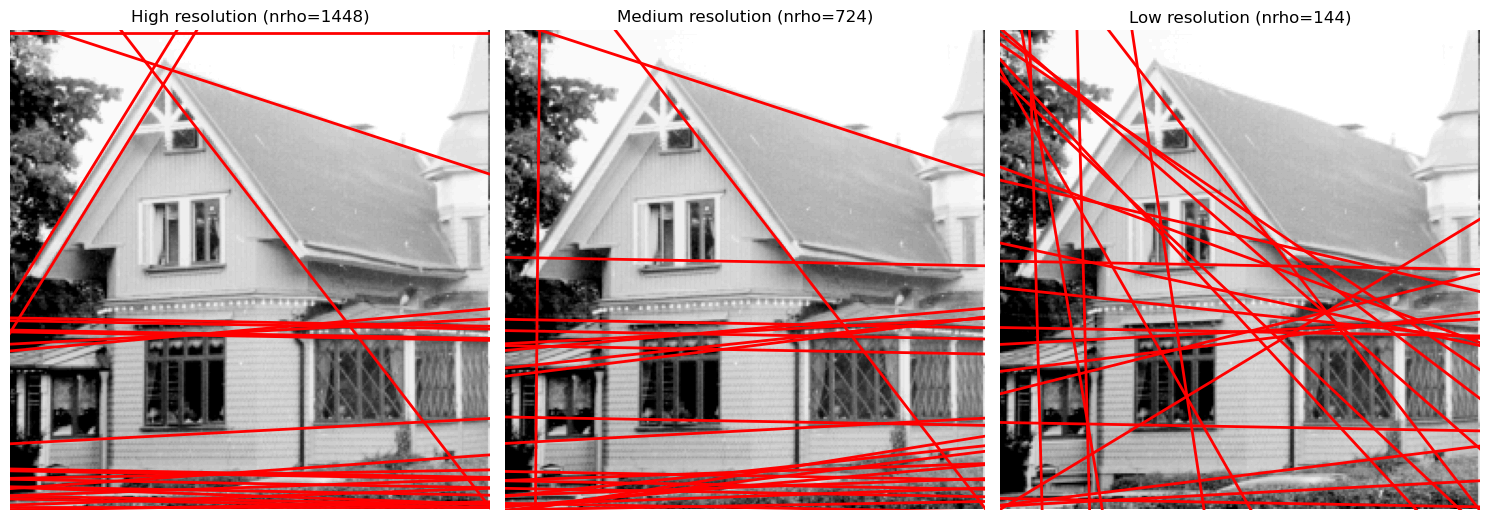

In [17]:
tools = np.load("Images-npy/few256.npy")
phone = np.load("Images-npy/phonecalc256.npy")
house = np.load("Images-npy/godthem256.npy")

H,W = tools.shape

# theta
dtheta = np.pi / 180 # one degree
theta_max = np.pi / 2
ntheta = int(2*theta_max / dtheta)

# rho
rho_max = np.sqrt((W)**2 + (H)**2)
nrho_range = [int(2*rho_max / 0.5), int(2*rho_max / 1), int(2*rho_max / 5)]

nlines = 25
scale = 4
gradmagnthreshold = 8

f = plt.figure(figsize=(15, 7))
plt.close('all')

for i in range(3):
    ax = f.add_subplot(1, 3, i + 1)

    if i == 0:
        nrho = nrho_range[0]
        ax.set_title('High resolution (nrho={})'.format(nrho))
        plt.sca(ax)
        houghedgeline(house, scale, gradmagnthreshold, nrho, ntheta, nlines, verbose = 2)

    elif i == 1:
        nrho = nrho_range[1]
        ax.set_title('Medium resolution (nrho={})'.format(nrho))
        plt.sca(ax)
        houghedgeline(house, scale, gradmagnthreshold, nrho, ntheta, nlines, verbose = 2)

    else:
        nrho = nrho_range[2]
        ax.set_title('Low resolution (nrho={})'.format(nrho))
        plt.sca(ax)
        houghedgeline(house, scale, gradmagnthreshold, nrho, ntheta, nlines, verbose = 2)
        
    ax.axis('off')
        
plt.tight_layout()
plt.show()

- High number of cells:
High precision because the space becomes more finely discretized, allowing for more differentiation between lines and making their identification easier. However, may result in multiple responses for the same actual edge, as points from the same edge might vote in several neighboring cells.
High computational time because the accumulator requires more memory and more processing for the votes (more votes to compute).

- Low number of cells:
Lower accuracy, there may be more ambiguity in identifying edges, especially in cases where fine details are important. Points from different edges may vote in the same cell by mistake because of the low resolution. However, less multiple responses.
Decreased computational time because there are fewer cells to iterate through and fewer votes to accumulate.

###  Accumulator incrementation improvement

(256, 256) (256, 256) (256, 256)
(724, 180) (724, 180) (724, 180)
(256, 256) (256, 256) (256, 256)
(724, 180) (724, 180) (724, 180)
(256, 256) (256, 256) (256, 256)
(724, 180) (724, 180) (724, 180)
(256, 256) (256, 256) (256, 256)
(724, 180) (724, 180) (724, 180)
(256, 256) (256, 256) (256, 256)
(724, 180) (724, 180) (724, 180)
(256, 256) (256, 256) (256, 256)
(724, 180) (724, 180) (724, 180)


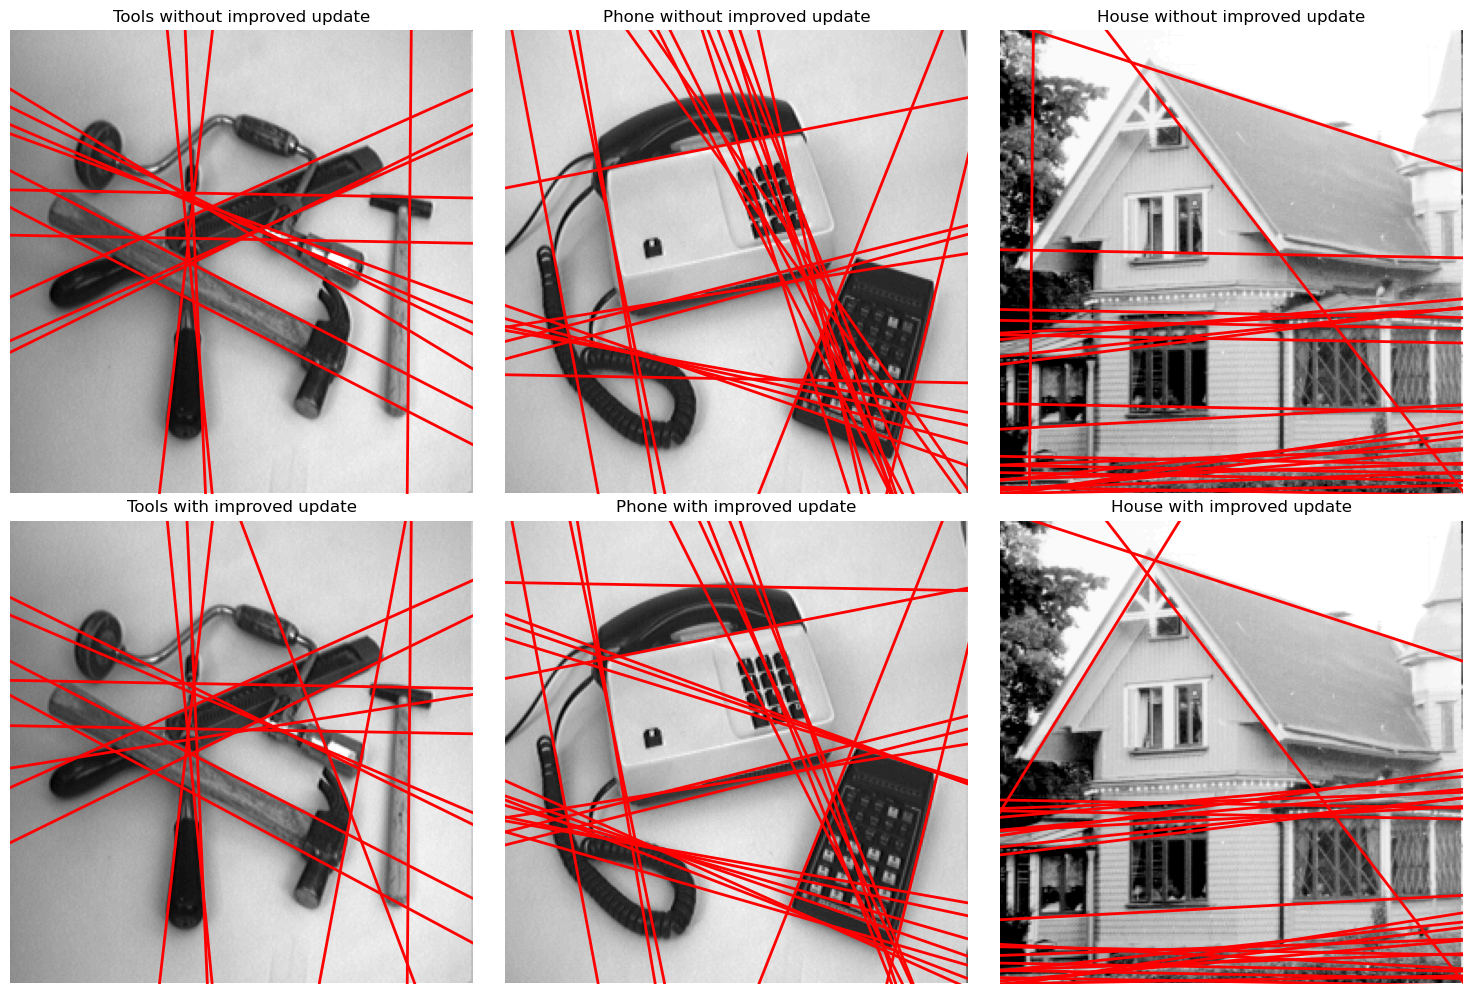

In [2]:
tools = np.load("Images-npy/few256.npy")
phone = np.load("Images-npy/phonecalc256.npy")
house = np.load("Images-npy/godthem256.npy")

H,W = tools.shape

# theta
dtheta = np.pi / 180 # one degree
theta_max = np.pi / 2
ntheta = int(2*theta_max / dtheta)

# rho
drho = 1 # one pixel
rho_max = np.sqrt((W)**2 + (H)**2)
nrho = int(2*rho_max / drho)

f = plt.figure(figsize=(15, 10))
plt.close('all')

for i in range(2):
    for j in range(3):
        idx = i * 3 + j
        ax = f.add_subplot(2, 3, idx + 1)

        if i == 0:
            if j == 0:
                plt.sca(ax)
                ax.set_title('Tools without improved update')
                houghedgeline(tools, 4, 8, nrho, ntheta, 15, verbose = 2)
            elif j == 1:
                plt.sca(ax)
                ax.set_title('Phone without improved update')
                houghedgeline(phone, 4, 8, nrho, ntheta, 25, verbose = 2)
            else:
                plt.sca(ax)
                ax.set_title('House without improved update')
                houghedgeline(house, 4, 8, nrho, ntheta, 25, verbose = 2)

        else:
            if j == 0:
                plt.sca(ax)
                ax.set_title('Tools with improved update')
                houghedgeline2(tools, 4, 8, nrho, ntheta, 15, verbose = 2)
            elif j == 1:
                plt.sca(ax)
                ax.set_title('Phone with improved update')
                houghedgeline2(phone, 4, 8, nrho, ntheta, 25, verbose = 2)
            else:
                plt.sca(ax)
                ax.set_title('House with improved update')
                houghedgeline2(house, 4, 8, nrho, ntheta, 25, verbose = 2)
                
        ax.axis('off')
        
plt.tight_layout()
plt.show()

In complex images, we could face a lot of noise, so I tried to find a better balance between detecting both strong and weak edges. By using the logarithm on the gradient magnitude, it is possible to do so. 

Furthermore, I tried to take into account the gradient direction. An edge is supposed to be perpendicular to the gradient direction, meaning that in our coordinate system, θ is supposed to be aligned with the gradient direction. Noting $\phi$ the angle between the x-axis and the local gradient, we can compute the alignment by taking for example, $cos⁡(|(|\theta-\phi|)|)$, which is maximum when the angles are aligned.

**I finally used: $h(|\nabla|)=log(1+|\nabla|)cos⁡(|(|\theta-\phi|)|)$, where $\phi = arctan(\frac{L_y}{L_x})$.**

The implementation slightly improved the results.